In [1]:
# Montar o google drive no coolab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Bibliotecas

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from itertools import chain

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from transformers import BertTokenizer, RobertaTokenizer, BertTokenizerFast, BertModel, BertForSequenceClassification
import torch
import torch.nn.functional as F
import torch.nn as nn

from sklearn.metrics import classification_report
from sklearn import metrics

import pickle
import re
import os
from tqdm import tqdm
import ast
import random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset


## Importando DataFrames

In [3]:
df_test_GPTrelev = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/gpt-3/1-10_relevancia/prediction_GPTrelev_MinTL.csv')
df_test_w2vreglog = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/baseline/prediction_baseline_RL_MinTL.csv')
df_test_softbert = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/BERT/prediction_BERT_MinTL.csv')

In [4]:
# Renomear colunas no df_test_GPTrelev
df_test_GPTrelev = df_test_GPTrelev.rename(columns={'predict_Diagnosed_YN': 'predict_GPTrelev', 'qt_msgs_lidas': 'qtd_msgs_lidas_GPTrelev'})

# Renomear colunas no df_test_w2vreglog
df_test_w2vreglog = df_test_w2vreglog.rename(columns={'prediction': 'predict_w2vreglog', 'qtd_msgs_lidas': 'qtd_msgs_lidas_w2vreglog'})

# Renomear colunas no df_test_softbert
df_test_softbert = df_test_softbert.rename(columns={'prediction': 'predict_softbert', 'qtd_msgs_lidas': 'qtd_msgs_lidas_softbert'})

In [5]:
# Unir df_test_w2vreglog e df_test_softbert
df_merged = pd.merge(df_test_w2vreglog[['User_ID', 'Diagnosed_YN', 'predict_w2vreglog', 'qtd_msgs_lidas_w2vreglog']],
                     df_test_softbert[['User_ID', 'predict_softbert', 'qtd_msgs_lidas_softbert']],
                     on='User_ID',
                     how='inner')

# Unir o resultado com df_test_GPTrelev
df_final = pd.merge(df_merged,
                    df_test_GPTrelev[['User_ID', 'label_min', 'predict_GPTrelev', 'qtd_msgs_lidas_GPTrelev']],
                    on='User_ID',
                    how='inner')


In [6]:
df_final['Erro_w2vreglog'] = (df_final['predict_w2vreglog'] != df_final['Diagnosed_YN']).astype(int)
df_final['Erro_softbert'] = (df_final['predict_softbert'] != df_final['Diagnosed_YN']).astype(int)
df_final['Erro_GPTrelev'] = (df_final['predict_GPTrelev'] != df_final['Diagnosed_YN']).astype(int)

In [7]:
df_final.to_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/analise_erro.pkl')
# df_final = pd.read_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/analise_erro.pkl')
df_final.head()

,User_ID,Diagnosed_YN,predict_w2vreglog,qtd_msgs_lidas_w2vreglog,predict_softbert,qtd_msgs_lidas_softbert,label_min,predict_GPTrelev,qtd_msgs_lidas_GPTrelev,Erro_w2vreglog,Erro_softbert,Erro_GPTrelev
0,D_40,1,0,507,1,28,"['3', '1', '1', '6', '2', '2', '1', '2', '6', ...",1,10,1,0,0
1,D_252,1,0,1463,1,22,"['3', '1', '3', '2', '6', '1', '2', '0', '2', ...",1,12,1,0,0
2,D_373,1,1,30,1,20,"['0', '0', '0', '2', '6', '0', '2', '1', '1', ...",1,39,0,0,0
3,D_99,1,0,1761,1,20,"['1', '2', '2', '0', '6', '0', '7', '2', '6', ...",1,10,1,0,0
4,D_1596,1,0,1447,1,20,"['2', '1', '2', '2', '2', '6', '2', '3', '3', ...",1,10,1,0,0


## Análise de erros

1. Selecionar aleatoriamente N instâncias de teste positivas e N negativas que tenham sido incorretamente classificadas; se possível, considere N como o nro total de instâncias positivas incorretas do conjunto de teste
2. Registrar a quantidade (%) dessas instâncias que o baseline errou também, e descartar
3. Considerando apenas o restante, ou seja, instâncias que o GPTrelev classificou errado e o baseline certo

In [8]:
df_final.value_counts('predict_GPTrelev', dropna=False)

,count
predict_GPTrelev,
1,2421
0,275


In [9]:
df_final.value_counts('Diagnosed_YN', dropna=False)

,count
Diagnosed_YN,
0,2359
1,337


In [10]:
# selecionar aleatoriamente N instâncias positivas e N negativas que tenham sido incorretamente classificadas
# N = total de instâncias positivas incorretas

qtd_positivas = len(df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['Diagnosed_YN'] == 1)]) # instâncias positivas classificadas incorretamente
qtd_negativas = len(df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['Diagnosed_YN'] == 0)]) # instâncias negativas classificadas incorretamente

print(f'Quantidade de instâncias positivas classificadas incorretamente: {qtd_positivas}')
print(f'Quantidade de instâncias negativas classificadas incorretamente: {qtd_negativas}')

Quantidade de instâncias positivas classificadas incorretamente: 10
Quantidade de instâncias negativas classificadas incorretamente: 2094


### Intersecções

In [40]:
# selecionar aleatoriamente N instâncias positivas e N negativas que tenham sido incorretamente classificadas
# N = total de instâncias positivas incorretas

qtd_concordancia_positivas = len(df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['predict_w2vreglog'] == 1)])
qtd_concordancia_negativas = len(df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['predict_w2vreglog'] == 0)])
qtd_discordancia_positivas = len(df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['predict_w2vreglog'] == 0)])
qtd_discordancia_negativas = len(df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['predict_w2vreglog'] == 1)])

print(f'Quantidade de concordâncias positivas classificadas: {qtd_concordancia_positivas}')
print(f'Quantidade de concordâncias negativas classificadas: {qtd_concordancia_negativas}')
print(f'Quantidade de discordâncias positivas classificadas: {qtd_discordancia_positivas}')
print(f'Quantidade de discordâncias negativas classificadas: {qtd_discordancia_negativas}')

Quantidade de concordâncias positivas classificadas: 78
Quantidade de concordâncias negativas classificadas: 273
Quantidade de discordâncias positivas classificadas: 2343
Quantidade de discordâncias negativas classificadas: 2


In [41]:
df_final.shape

(2696, 12)

### Métricas de desempenho

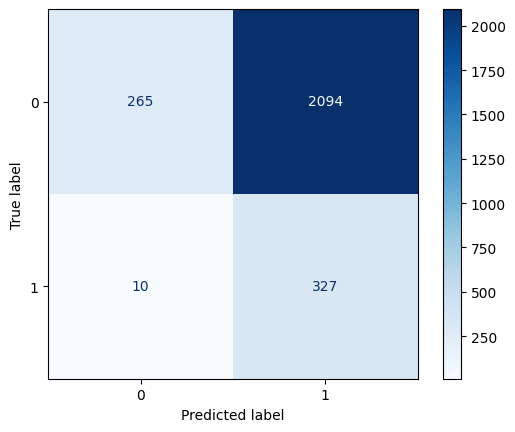

 
              precision    recall  f1-score   support

           0       0.96      0.11      0.20      2359
           1       0.14      0.97      0.24       337

    accuracy                           0.22      2696
   macro avg       0.55      0.54      0.22      2696
weighted avg       0.86      0.22      0.21      2696



In [11]:
# GPTrelev
y_test = df_final['Diagnosed_YN']
y_pred = df_final['predict_GPTrelev']
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(' ')
print(classification_report(y_test, y_pred))

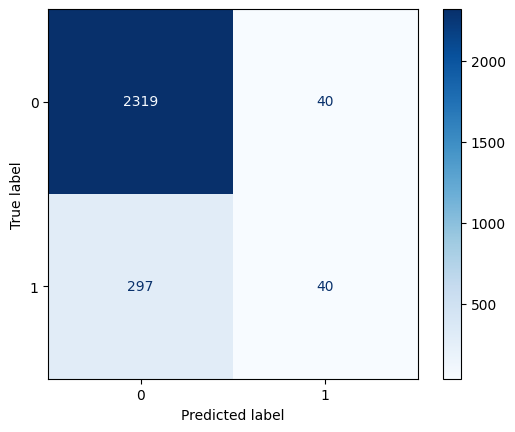

 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2359
           1       0.50      0.12      0.19       337

    accuracy                           0.88      2696
   macro avg       0.69      0.55      0.56      2696
weighted avg       0.84      0.88      0.84      2696



In [12]:
# W2V.logreg
y_test = df_final['Diagnosed_YN']
y_pred = df_final['predict_w2vreglog']
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(' ')
print(classification_report(y_test, y_pred))

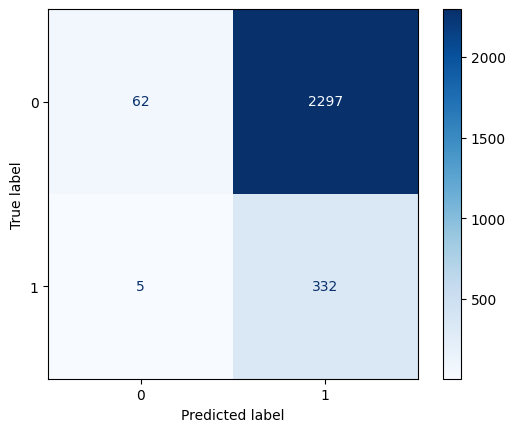

 
              precision    recall  f1-score   support

           0       0.93      0.03      0.05      2359
           1       0.13      0.99      0.22       337

    accuracy                           0.15      2696
   macro avg       0.53      0.51      0.14      2696
weighted avg       0.83      0.15      0.07      2696



In [13]:
# Soft.BERT
y_test = df_final['Diagnosed_YN']
y_pred = df_final['predict_softbert']
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(' ')
print(classification_report(y_test, y_pred))

### Distribuição dos escores

In [23]:
# Funções

# Substituição de texto por zero
def replace_phrases_with_zero(lst):
    new_lst = [0 if isinstance(item, str) and not item.isdigit() else int(item) for item in lst]
    return new_lst

# Obtenção da lista de notas
def escore_list(df):
  notas_list = list(chain.from_iterable(df['label_min']))
  notas_list_filtrada = [nota for nota in notas_list if nota not in (0, 1, 2)]

  # Contar a frequência dos valores
  contagens = Counter(notas_list_filtrada)

  # Criar um DataFrame a partir do dicionário
  df_contagens = pd.DataFrame(contagens.items(), columns=['notas', 'quantidade'])

  # Calcular o total de todas as quantidades
  total = df_contagens['quantidade'].sum()

  # Adicionar a coluna de percentual
  df_contagens['percentual'] = round((df_contagens['quantidade'] / total) * 100, 2)
  df_contagens.sort_values('notas', inplace=True)

  return df_contagens

# Obtenção da lista de notas
def escore_list_n_relev(df):
  notas_list = list(chain.from_iterable(df['label_min']))
  notas_list_filtrada = [nota for nota in notas_list if nota in (0, 1, 2)]

  # Contar a frequência dos valores
  contagens = Counter(notas_list_filtrada)

  # Criar um DataFrame a partir do dicionário
  df_contagens = pd.DataFrame(contagens.items(), columns=['notas', 'quantidade'])

  # Calcular o total de todas as quantidades
  total = df_contagens['quantidade'].sum()

  # Adicionar a coluna de percentual
  df_contagens['percentual'] = round((df_contagens['quantidade'] / total) * 100, 2)
  df_contagens.sort_values('notas', inplace=True)

  return df_contagens

# Obtenção da lista de notas
def escore_list_total(df):
  notas_list = list(chain.from_iterable(df['label_min']))

  # Contar a frequência dos valores
  contagens = Counter(notas_list)

  # Criar um DataFrame a partir do dicionário
  df_contagens = pd.DataFrame(contagens.items(), columns=['notas', 'quantidade'])

  # Calcular o total de todas as quantidades
  total = df_contagens['quantidade'].sum()

  # Adicionar a coluna de percentual
  df_contagens['percentual'] = round((df_contagens['quantidade'] / total) * 100, 2)
  df_contagens.sort_values('notas', inplace=True)

  return df_contagens

In [21]:
df_final['label_min'] = df_final['label_min'].apply(replace_phrases_with_zero)

# Dataframes de erros e acertos
df_final_erros = df_final[(df_final['Erro_GPTrelev'] == 1)]
df_final_acertos = df_final[(df_final['Erro_GPTrelev'] == 0)]

# Serparação nas classes positiva e negativa
df_final_erros_positiva = df_final_erros[df_final_erros['predict_GPTrelev'] == 1]
df_final_erros_negativa = df_final_erros[df_final_erros['predict_GPTrelev'] == 0]

df_final_acertos_positiva = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 1]
df_final_acertos_negativa = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 0]

print('Acertos da classe positiva')
df_escores_acertos_positiva = escore_list(df_final_acertos_positiva)
print(df_escores_acertos_positiva)
relevantes_acertos_positiva = df_escores_acertos_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_positiva}')

print('##############################')

print('Acertos da classe negativa')
df_escores_acertos_negativa = escore_list(df_final_acertos_negativa)
print(df_escores_acertos_negativa)
relevantes_acertos_negativa = df_escores_acertos_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_negativa}')

print('##############################')

print('Erros da classe positiva')
df_escores_erros_positiva = escore_list(df_final_erros_positiva)
print(df_escores_erros_positiva)
relevantes_erros_positiva = df_escores_erros_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_positiva}')

print('##############################')

print('Erros da classe negativa')
df_escores_erros_negativa = escore_list(df_final_erros_negativa)
print(df_escores_erros_negativa)
relevantes_erros_negativa = df_escores_erros_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_negativa}')

Acertos da classe positiva
   notas  quantidade  percentual
0      3        3928       50.28
4      4          86        1.10
6      5           9        0.12
1      6        3418       43.75
2      7         311        3.98
3      8          58        0.74
5      9           3        0.04
Quantidade de mensagens relevantes: 7813
##############################
Acertos da classe negativa
   notas  quantidade  percentual
1      3        1092       72.41
4      4          18        1.19
2      5           2        0.13
0      6         373       24.73
3      7          20        1.33
6      8           2        0.13
5      9           1        0.07
Quantidade de mensagens relevantes: 1508
##############################
Erros da classe positiva
   notas  quantidade  percentual
1      3       23357       56.04
3      4         499        1.20
5      5          34        0.08
0      6       16665       39.98
2      7         978        2.35
4      8         136        0.33
6      9          

In [22]:
df_final['label_min'] = df_final['label_min'].apply(replace_phrases_with_zero)

# Dataframes de erros e acertos
df_final_erros = df_final[(df_final['Erro_GPTrelev'] == 1)]
df_final_acertos = df_final[(df_final['Erro_GPTrelev'] == 0)]

# Serparação nas classes positiva e negativa
df_final_erros_positiva = df_final_erros[df_final_erros['predict_GPTrelev'] == 1]
df_final_erros_negativa = df_final_erros[df_final_erros['predict_GPTrelev'] == 0]

df_final_acertos_positiva = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 1]
df_final_acertos_negativa = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 0]

print('Acertos da classe positiva')
df_escores_acertos_positiva = escore_list_n_relev(df_final_acertos_positiva)
print(df_escores_acertos_positiva)
relevantes_acertos_positiva = df_escores_acertos_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_positiva}')

print('##############################')

print('Acertos da classe negativa')
df_escores_acertos_negativa = escore_list_n_relev(df_final_acertos_negativa)
print(df_escores_acertos_negativa)
relevantes_acertos_negativa = df_escores_acertos_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_negativa}')

print('##############################')

print('Erros da classe positiva')
df_escores_erros_positiva = escore_list_n_relev(df_final_erros_positiva)
print(df_escores_erros_positiva)
relevantes_erros_positiva = df_escores_erros_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_positiva}')

print('##############################')

print('Erros da classe negativa')
df_escores_erros_negativa = escore_list_n_relev(df_final_erros_negativa)
print(df_escores_erros_negativa)
relevantes_erros_negativa = df_escores_erros_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_negativa}')

Acertos da classe positiva
   notas  quantidade  percentual
0      0      117088       88.86
1      1        5304        4.03
2      2        9382        7.12
Quantidade de mensagens relevantes: 131774
##############################
Acertos da classe negativa
   notas  quantidade  percentual
0      0      100399       89.25
1      1        6376        5.67
2      2        5722        5.09
Quantidade de mensagens relevantes: 112497
##############################
Erros da classe positiva
   notas  quantidade  percentual
0      0      747631       87.66
2      1       39127        4.59
1      2       66133        7.75
Quantidade de mensagens relevantes: 852891
##############################
Erros da classe negativa
   notas  quantidade  percentual
0      0        3849       89.76
2      1         216        5.04
1      2         223        5.20
Quantidade de mensagens relevantes: 4288


In [24]:
df_final['label_min'] = df_final['label_min'].apply(replace_phrases_with_zero)

# Dataframes de erros e acertos
df_final_erros = df_final[(df_final['Erro_GPTrelev'] == 1)]
df_final_acertos = df_final[(df_final['Erro_GPTrelev'] == 0)]

# Serparação nas classes positiva e negativa
df_final_erros_positiva = df_final_erros[df_final_erros['predict_GPTrelev'] == 1]
df_final_erros_negativa = df_final_erros[df_final_erros['predict_GPTrelev'] == 0]

df_final_acertos_positiva = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 1]
df_final_acertos_negativa = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 0]

print('Acertos da classe positiva')
df_escores_acertos_positiva = escore_list_total(df_final_acertos_positiva)
print(df_escores_acertos_positiva)
relevantes_acertos_positiva = df_escores_acertos_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_positiva}')

print('##############################')

print('Acertos da classe negativa')
df_escores_acertos_negativa = escore_list_total(df_final_acertos_negativa)
print(df_escores_acertos_negativa)
relevantes_acertos_negativa = df_escores_acertos_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_negativa}')

print('##############################')

print('Erros da classe positiva')
df_escores_erros_positiva = escore_list_total(df_final_erros_positiva)
print(df_escores_erros_positiva)
relevantes_erros_positiva = df_escores_erros_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_positiva}')

print('##############################')

print('Erros da classe negativa')
df_escores_erros_negativa = escore_list_total(df_final_erros_negativa)
print(df_escores_erros_negativa)
relevantes_erros_negativa = df_escores_erros_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_negativa}')

Acertos da classe positiva
   notas  quantidade  percentual
0      0      117088       83.88
2      1        5304        3.80
4      2        9382        6.72
1      3        3928        2.81
7      4          86        0.06
9      5           9        0.01
3      6        3418        2.45
5      7         311        0.22
6      8          58        0.04
8      9           3        0.00
Quantidade de mensagens relevantes: 139587
##############################
Acertos da classe negativa
   notas  quantidade  percentual
0      0      100399       88.07
1      1        6376        5.59
2      2        5722        5.02
4      3        1092        0.96
7      4          18        0.02
5      5           2        0.00
3      6         373        0.33
6      7          20        0.02
9      8           2        0.00
8      9           1        0.00
Quantidade de mensagens relevantes: 114005
##############################
Erros da classe positiva
   notas  quantidade  percentual
0      0      

### Elapsed

In [32]:
# Import e criação do dataframe para análise
df_elapsed = pd.read_excel('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/elapsed_times.xlsx', sheet_name='diagnosed_test_depress')


df_merged = pd.merge(df_final, df_elapsed, on='User_ID', how='left')
df_merged.head()

,User_ID,Diagnosed_YN,predict_w2vreglog,qtd_msgs_lidas_w2vreglog,predict_softbert,qtd_msgs_lidas_softbert,label_min,predict_GPTrelev,qtd_msgs_lidas_GPTrelev,Erro_w2vreglog,Erro_softbert,Erro_GPTrelev,Msg_Date,End,Elapsed,Old
0,D_40,1,0,507,1,28,"[0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",1,10,1,0,0,18/05/2021,16/05/2021,2.0,0.0
1,D_252,1,0,1463,1,22,"[0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, ...",1,12,1,0,0,09/03/2021,07/03/2021,2.0,0.0
2,D_373,1,1,30,1,20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,39,0,0,0,27/01/2021,14/01/2021,13.0,0.0
3,D_99,1,0,1761,1,20,"[0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, ...",1,10,1,0,0,03/05/2021,01/05/2021,2.0,0.0
4,D_1596,1,0,1447,1,20,"[0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, ...",1,10,1,0,0,01/07/2020,01/07/2018,731.0,1.0


In [36]:
df_merged.pivot_table(index='Erro_GPTrelev', columns='Old', aggfunc='count', values='Diagnosed_YN')

Old,0.0,1.0
Erro_GPTrelev,,
0,248,79
1,6,4


### H1 - Timeline negativa apresenta indícios de depressão

Distribuição de notas para os casos de erro

In [ ]:
def replace_phrases_with_zero(lst):
    new_lst = [0 if isinstance(item, str) and not item.isdigit() else int(item) for item in lst]
    return new_lst

df_final['label_min'] = df_final['label_min'].apply(replace_phrases_with_zero)

# Distribuição das notas nestas timelines
df_final_erros = df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['Diagnosed_YN'] == 0)]

In [ ]:
from collections import Counter
from itertools import chain

notas_list_erros = list(chain.from_iterable(df_final_erros['label_min']))

# Contar a frequência dos valores
contagens_erros = Counter(notas_list_erros)

# Criar um DataFrame a partir do dicionário
df_contagens_erros = pd.DataFrame(contagens_erros.items(), columns=['notas', 'quantidade'])

# Calcular o total de todas as quantidades
total = df_contagens_erros['quantidade'].sum()

# Adicionar a coluna de percentual
df_contagens_erros['percentual'] = round((df_contagens_erros['quantidade'] / total) * 100, 2)
df_contagens_erros.sort_values('notas')

,notas,quantidade,percentual
0,0,418721,72.45
2,1,44635,7.72
1,2,71564,12.38
4,3,24409,4.22
6,4,486,0.08
8,5,1,0.00
3,6,17005,2.94
5,7,982,0.17
7,8,127,0.02


In [ ]:
# Média geral
sum(notas_list_erros)/len(notas_list_erros)

0.6451629090028204

Distribuição de notas para a classe positiva

In [ ]:
df_final_positivo = df_final[df_final['Diagnosed_YN'] == 1]

notas_list_pos = list(chain.from_iterable(df_final_positivo['label_min']))

# Contar a frequência dos valores
contagens_pos = Counter(notas_list_pos)

# Criar um DataFrame a partir do dicionário
df_contagens_pos = pd.DataFrame(contagens_pos.items(), columns=['notas', 'quantidade'])

# Calcular o total de todas as quantidades
total = df_contagens_pos['quantidade'].sum()

# Adicionar a coluna de percentual
df_contagens_pos['percentual'] = round((df_contagens_pos['quantidade'] / total) * 100, 2)
df_contagens_pos.sort_values('notas')

,notas,quantidade,percentual
0,0,60960,72.65
2,1,5500,6.55
4,2,9582,11.42
1,3,3988,4.75
7,4,82,0.10
8,5,2,0.00
3,6,3435,4.09
5,7,309,0.37
6,8,56,0.07


In [ ]:
# Média geral
sum(notas_list_pos)/len(notas_list_pos)

0.7172462282813357

### H2 - Distribuição de notas para a matriz de confusão

In [ ]:
df_final_TP = df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['Diagnosed_YN'] == 1)]
df_final_TN = df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['Diagnosed_YN'] == 0)]
df_final_FP = df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['Diagnosed_YN'] == 0)]
df_final_FN = df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['Diagnosed_YN'] == 1)]

In [ ]:
dataframe_list = ['TP', 'TN', 'FP', 'FN']

In [ ]:
for i in dataframe_list:
  print(i)
  notas_list = list(chain.from_iterable(globals()[f'df_final_{i}']['label_min']))

  # Contar a frequência dos valores
  contagens = Counter(notas_list)

  # Criar um DataFrame a partir do dicionário
  globals()[f'df_contagens_{i}'] = pd.DataFrame(contagens.items(), columns=['notas', 'quantidade'])

  # Calcular o total de todas as quantidades
  total = globals()[f'df_contagens_{i}']['quantidade'].sum()

  # Adicionar a coluna de percentual
  globals()[f'df_contagens_{i}']['percentual'] = round((globals()[f'df_contagens_{i}']['quantidade'] / total) * 100, 2)
  print(globals()[f'df_contagens_{i}'].sort_values('notas'))
  print('--------------------------------------')

TP
   notas  quantidade  percentual
0      0       60960       72.65
2      1        5500        6.55
4      2        9582       11.42
1      3        3988        4.75
7      4          82        0.10
8      5           2        0.00
3      6        3435        4.09
5      7         309        0.37
6      8          56        0.07
--------------------------------------
TN
   notas  quantidade  percentual
0      0        8416       88.95
1      1         794        8.39
2      2         232        2.45
4      3          16        0.17
5      6           3        0.03
3      7           1        0.01
--------------------------------------
FP
   notas  quantidade  percentual
0      0      418721       72.45
2      1       44635        7.72
1      2       71564       12.38
4      3       24409        4.22
6      4         486        0.08
8      5           1        0.00
3      6       17005        2.94
5      7         982        0.17
7      8         127        0.02
----------------------